# Adult Income Classification

______

In this example, we would try to classify if the income is high i.e. >50 k or low i.e. < 50 k.

The dataset can be downloaded from : http://archive.ics.uci.edu/ml/datasets/Adult

### Listing of attributes: 

Class: >50K, <=50K. 

age: continuous. 

workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 

fnlwgt: continuous. 

education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 

education-num: continuous. 

marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 

occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 

relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 

race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 

sex: Female, Male. 

capital-gain: continuous. 

capital-loss: continuous. 

hours-per-week: continuous. 

native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, 
Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.



In [4]:
import os
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score , classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report


In [5]:
# read .csv from provided dataset
csv_filename="datasets/adult.data"

df = pd.read_csv(csv_filename, header=None,
                names=["Age", "Work-Class", "fnlwgt",
                "Education", "Education-Num",
                "Marital-Status", "Occupation",
                "Relationship", "Race", "Sex",
                "Capital-gain", "Capital-loss",
                "Hours-per-week", "Native-Country",
                "Earnings-Raw"])

In [6]:
df.replace([' <=50K',' >50K'],[0,1],inplace=True)

In [7]:
df.tail()

,Age,Work-Class,fnlwgt,Education,Education-Num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-Country,Earnings-Raw
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,1


The adult file itself contains two blank lines at the end of the file. By default, pandas
will interpret the penultimate new line to be an empty (but valid) row. To remove
this, we remove any line with invalid numbers (the use of inplace just makes sure
the same Dataframe is affected, rather than creating a new one):

In [8]:
df.dropna(how='all', inplace=True)

In [9]:
feature_names = df.columns

The results show each of the feature names that are stored inside an Index object
from pandas.

The Adult dataset contains several categorical features, with Work-Class being one
example. While we could argue that some values are of higher rank than others (for
instance, a person with a job is likely to have a better income than a person without),
it doesn't make sense for all values. For example, a person working for the state
government is not more or less likely to have a higher income than someone working
in the private sector.
We can view the unique values for this feature in the dataset using the
unique() function:

In [10]:
df["Work-Class"].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay', ' Never-worked'], dtype=object)

There are some missing values in the preceding dataset, but they won't affect our
computations in this example.

#### Selecting the best individual features
If we have a number of features, the problem of finding the best subset is a difficult
task. 

The scikit-learn package has a number of transformers for performing univariate
feature selection. They include SelectKBest, which returns the k best performing
features, and SelectPercentile, which returns the top r% of features. In both cases,
there are a number of methods of computing the quality of a feature.

There are many different methods to compute how effectively a single feature
correlates with a class value. A commonly used method is the chi-squared (χ2) test.
Other methods include mutual information and entropy.

We can observe single-feature tests in action using our Adult dataset. First, we
extract a dataset and class values from our pandas DataFrame. We get a selection of
the features:

In [11]:
X = df[["Age", "Education-Num", "Capital-gain", "Capital-loss", "Hours-per-week"]].values

We will also create a target class array by testing whether the Earnings-Raw value
is above $50,000 or not. If it is, the class will be True. Otherwise, it will be False.
Let's look at the code:

In [12]:
y = (df["Earnings-Raw"]).values

In [13]:
y

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

Next, we create our transformer using the chi2 function and a SelectKBest
transformer:

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
transformer = SelectKBest(score_func=chi2, k=3)

Running fit_transform will call fit and then transform with the same dataset.
The result will create a new dataset, choosing only the best three features.
Let's look at the code:

In [15]:
Xt_chi2 = transformer.fit_transform(X, y)

The resulting matrix now only contains three features. We can also get the scores
for each column, allowing us to find out which features were used. Let's look at
the code:

In [16]:
print(transformer.scores_)

[  8.60061182e+03   2.40142178e+03   8.21924671e+07   1.37214589e+06
   6.47640900e+03]


The highest values are for the first, third, and fourth columns Correlates to the Age,
Capital-Gain, and Capital-Loss features. Based on a univariate feature selection,
these are the best features to choose.

We could also implement other correlations, such as the Pearson's correlation
coefficient. This is implemented in SciPy, a library used for scientific computing
(scikit-learn uses it as a base).

In [17]:
from scipy.stats import pearsonr

The preceding function almost fits the interface needed to be used in scikit-learn's
univariate transformers. The function needs to accept two arrays (x and y in our
example) as parameters and returns two arrays, the scores for each feature and the
corresponding p-values. The chi2 function we used earlier only uses the required
interface, which allowed us to just pass it directly to SelectKBest.

The pearsonr function in SciPy accepts two arrays; however, the X array it accepts is
only one dimension. We will write a wrapper function that allows us to use this for
multivariate arrays like the one we have. Let's look at the code:

In [18]:
def multivariate_pearsonr(X, y):
    scores, pvalues = [], []
    for column in range(X.shape[1]):
        cur_score, cur_p = pearsonr(X[:,column], y)
        scores.append(abs(cur_score))
        pvalues.append(cur_p)
    return (np.array(scores), np.array(pvalues))

The Pearson value could be between -1 and 1. A value of 1 implies a
perfect correlation between two variables, while a value of -1 implies a
perfect negative correlation, that is, high values in one variable give low
values in the other and vice versa. Such features are really useful to have,
but would be discarded. For this reason, we have stored the absolute
value in the scores array, rather than the original signed value.

In [19]:
transformer = SelectKBest(score_func=multivariate_pearsonr, k=3)
Xt_pearson = transformer.fit_transform(X, y)
print(transformer.scores_)

[ 0.2340371   0.33515395  0.22332882  0.15052631  0.22968907]


This returns a different set of features! The features chosen this way are the first,
second, and fifth columns: the Age, Education, and Hours-per-week worked. This
shows that there is not a definitive answer to what the best features are— it depends
on the metric.

We can see which feature set is better by running them through a classifier. Keep in
mind that the results only indicate which subset is better for a particular classifier
and/or feature combination—there is rarely a case in data mining where one method
is strictly better than another in all cases! Let's look at the code:


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
clf = DecisionTreeClassifier(random_state=14)
scores_chi2 = cross_val_score(clf, Xt_chi2, y, scoring='accuracy')
scores_pearson = cross_val_score(clf, Xt_pearson, y, scoring='accuracy')

In [21]:
print("Chi2 performance: {0:.3f}".format(scores_chi2.mean()))
print("Pearson performance: {0:.3f}".format(scores_pearson.mean()))

Chi2 performance: 0.829
Pearson performance: 0.771


It is worth remembering the goal of this data mining activity: predicting wealth.
Using a combination of good features and feature selection, we can achieve 83
percent accuracy using just three features of a person!

### Principal Components Analysis

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
Xd = pca.fit_transform(X)

In [23]:
np.set_printoptions(precision=3, suppress=True)
pca.explained_variance_ratio_

array([ 0.997,  0.003,  0.   ,  0.   ,  0.   ])

The result, array([ 0.997,  0.003,  0.   ,  0.   ,  0.   ]), shows
us that the first feature accounts for 99.7 percent of the variance in the dataset,
the second accounts for 0.3 percent, and so on. By the fourth feature, less than
one-tenth of a percent of the variance is contained in the feature. The other
features explain even less.

In [24]:
clf = DecisionTreeClassifier(random_state=14)
original_scores = cross_val_score(clf, X, y, scoring='accuracy')

In [25]:
print("The average score from the original dataset is {:.4f}".format(np.mean(original_scores)))

The average score from the original dataset is 0.8111


In [26]:
clf = DecisionTreeClassifier(random_state=14)
scores_reduced = cross_val_score(clf, Xd, y, scoring='accuracy')

In [27]:
print("The average score from the reduced dataset is {:.4f}".format(np.mean(scores_reduced)))

The average score from the reduced dataset is 0.8135


___

In [28]:
df.replace(' ?',np.nan,inplace=True)

In [29]:
df.loc[26,:]

Age                           19
Work-Class               Private
fnlwgt                    168294
Education                HS-grad
Education-Num                  9
Marital-Status     Never-married
Occupation          Craft-repair
Relationship           Own-child
Race                       White
Sex                         Male
Capital-gain                   0
Capital-loss                   0
Hours-per-week                40
Native-Country     United-States
Earnings-Raw                   0
Name: 26, dtype: object

In [30]:
df.shape

(32561, 15)

In [31]:
#We can also specify to only drop rows that are complete missing all data
df.dropna(inplace=True)


In [32]:
df.shape

(30162, 15)

___

In [33]:
df.head()

,Age,Work-Class,fnlwgt,Education,Education-Num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-Country,Earnings-Raw
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [36]:
for col in df.columns:
    if df[col].dtype != 'int64':
        print ("For: {}, Total unique values are {} - \n {}".format(col ,
                                                        len(pd.Series(df[col].values.ravel()).unique()),
                                                        pd.Series(df[col].values.ravel()).unique()))
        print ('\n')

For: Work-Class, Total unique values are 7 - 
 [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' Self-emp-inc' ' Without-pay']


For: Education, Total unique values are 16 - 
 [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' 7th-8th' ' Doctorate' ' Assoc-voc' ' Prof-school'
 ' 5th-6th' ' 10th' ' Preschool' ' 12th' ' 1st-4th']


For: Marital-Status, Total unique values are 7 - 
 [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']


For: Occupation, Total unique values are 14 - 
 [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Transport-moving' ' Farming-fishing'
 ' Machine-op-inspct' ' Tech-support' ' Craft-repair' ' Protective-serv'
 ' Armed-Forces' ' Priv-house-serv']


For: Relationship, Total unique values are 6 - 
 [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']

Now all of these features are categorical classes, but most scikit-learn classifiers (in particular the Decision Trees we plan to use), expect real-valued attributes. We can easily convert sex  to a binary value (0=female,1=male). We will use the LabelEncoder class from scikit-learn:

In [39]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(df['Sex'])
print ("Categorical classes:", label_encoder.classes_)
integer_classes = label_encoder.transform(label_encoder.classes_)
print ("Integer classes:", integer_classes)
t = label_encoder.transform(df['Sex'])
df['Sex'] = t
print ('Feature names:',feature_names)
print ('Features:', df['Sex'][10:16])

Categorical classes: [' Female' ' Male']
Integer classes: [0 1]
Feature names: Index(['Age', 'Work-Class', 'fnlwgt', 'Education', 'Education-Num',
       'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-gain', 'Capital-loss', 'Hours-per-week', 'Native-Country',
       'Earnings-Raw'],
      dtype='object')
Features: 10    1
11    1
12    0
13    1
15    1
16    1
Name: Sex, dtype: int64


Now, we have to convert other categorical features. Since we have three different classes, we cannot convert to binary values (and using 0/1/2 values would imply an order, something we do not want). We use pandas get_dummies method for it or we can also use the OneHotEncoder to get three different attributes:

In [40]:
categorical_features = []
for col in df.columns:
    if df[col].dtype != 'int64':
        categorical_features.append(col)
categorical_features

['Work-Class',
 'Education',
 'Marital-Status',
 'Occupation',
 'Relationship',
 'Race',
 'Native-Country']

In [41]:
df.shape[0]

30162

In [42]:
onehot_df = pd.get_dummies(df)

In [43]:
onehot_df.head()

,Age,fnlwgt,Education-Num,Sex,Capital-gain,Capital-loss,Hours-per-week,Earnings-Raw,Work-Class_ Federal-gov,Work-Class_ Local-gov,...,Native-Country_ Portugal,Native-Country_ Puerto-Rico,Native-Country_ Scotland,Native-Country_ South,Native-Country_ Taiwan,Native-Country_ Thailand,Native-Country_ Trinadad&Tobago,Native-Country_ United-States,Native-Country_ Vietnam,Native-Country_ Yugoslavia
0,39,77516,13,1,2174,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,1,0,0,13,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,1,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,1,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
onehot_df.columns

Index(['Age', 'fnlwgt', 'Education-Num', 'Sex', 'Capital-gain', 'Capital-loss',
       'Hours-per-week', 'Earnings-Raw', 'Work-Class_ Federal-gov',
       'Work-Class_ Local-gov',
       ...
       'Native-Country_ Portugal', 'Native-Country_ Puerto-Rico',
       'Native-Country_ Scotland', 'Native-Country_ South',
       'Native-Country_ Taiwan', 'Native-Country_ Thailand',
       'Native-Country_ Trinadad&Tobago', 'Native-Country_ United-States',
       'Native-Country_ Vietnam', 'Native-Country_ Yugoslavia'],
      dtype='object', length=104)

In [ ]:
"""
from sklearn.preprocessing import OneHotEncoder

enc = LabelEncoder()

for f in categorical_features:

    label_encoder = enc.fit(df[f])
    print "Categorical classes:", label_encoder.classes_
    
    integer_classes = label_encoder.transform(label_encoder.classes_).reshape(
        len(pd.Series(df[f].values.ravel()).unique()), 1)
    print "Integer classes:", integer_classes
    
    enc = OneHotEncoder()
    one_hot_encoder = enc.fit(integer_classes)
    
    # First, convert clases to 0-(N-1) integers using label_encoder
    num_of_rows = df.shape[0]
    t = label_encoder.transform(df[f]).reshape(num_of_rows, 1)
    
    # Second, create a sparse matrix with three columns, each one indicating if the instance belongs to the class
    new_features = one_hot_encoder.transform(t)
    
    # Add the new features to df
    df = np.concatenate([df, new_features.toarray()], axis = 1)
    
    #Eliminate converted columns
    df.drop(f, axis=1, inplace=True)
    
    # Update feature names
    feature_names = ['age', 'sex', 'first_class', 'second_class', 'third_class']
    # Convert to numerical values
    df = df.astype(float)
    titanic_y = titanic_y.astype(float)
"""

In [45]:
features_list = list(onehot_df.columns)

In [46]:
features_list.remove('Earnings-Raw')

In [47]:
X = onehot_df[features_list]
y= onehot_df['Earnings-Raw']

### Feature importances with forests of trees

This examples shows the use of forests of trees to evaluate the importance of features on an artificial classification task. The red bars are the feature importances of the forest, along with their inter-trees variability.

In [48]:
# split dataset to 60% training and 40% testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=0)

In [50]:
print (X_train.shape, y_train.shape)

(18097, 103) (18097,)


### feature\_importances_

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [52]:
importances[indices[:5]]

array([ 0.17 ,  0.153,  0.093,  0.071,  0.066])

In [53]:
features = features_list
for f in range(5):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], features[indices[f]] ,importances[indices[f]]))

1. feature 1 - fnlwgt (0.170258)
2. feature 0 - Age (0.152898)
3. feature 6 - Hours-per-week (0.093478)
4. feature 32 - Marital-Status_ Married-civ-spouse (0.070931)
5. feature 4 - Capital-gain (0.065981)


In [54]:
best_features = []
for i in indices[:5]:
    best_features.append(features[i])

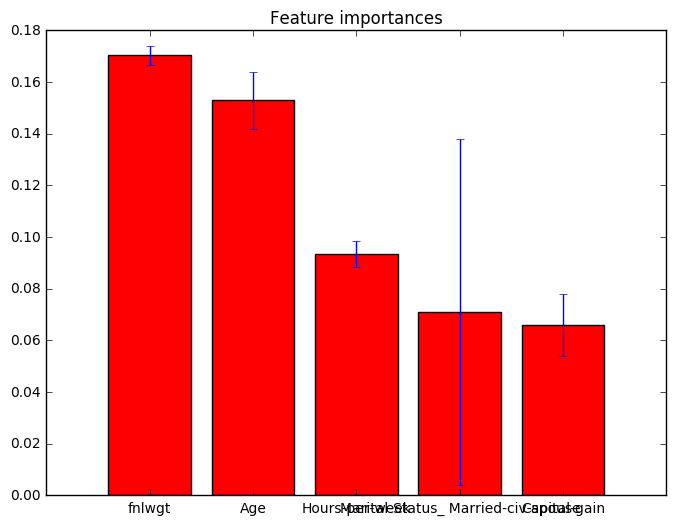

In [55]:
# Plot the top 5 feature importances of the forest
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(5), importances[indices][:5], 
       color="r",  yerr=std[indices][:5], align="center")
plt.xticks(range(5), best_features)
plt.xlim([-1, 5])
plt.show()

# Decision Tree accuracy and time elapsed caculation

In [56]:
t0=time()
print ("DecisionTree")

dt = DecisionTreeClassifier(min_samples_split=20,random_state=99)
# dt = DecisionTreeClassifier(min_samples_split=20,max_depth=5,random_state=99)

clf_dt=dt.fit(X_train,y_train)

print ("Acurracy: ", clf_dt.score(X_test,y_test))
t1=time()
print ("time elapsed: ", t1-t0)

DecisionTree
Acurracy:  0.827351844177
time elapsed:  0.605034589767456


## cross validation for DT

In [57]:
tt0=time()
print ("cross result========")
scores = cross_validation.cross_val_score(dt, X, y, cv=5)
print (scores)
print (scores.mean())
tt1=time()
print ("time elapsed: ", tt1-tt0)

cross result========
[ 0.825  0.821  0.829  0.833  0.831]
0.827962687655
time elapsed:  2.6721527576446533


### Tuning our hyperparameters using GridSearch

In [60]:
from sklearn.metrics import classification_report

pipeline = Pipeline([
    ('clf', DecisionTreeClassifier(criterion='entropy'))
])

parameters = {
    'clf__max_depth': (5, 25 , 50),
    'clf__min_samples_split': (2, 5, 10),
    'clf__min_samples_leaf': (1, 2, 3)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1')
grid_search.fit(X_train, y_train)

print ('Best score: %0.3f' % grid_search.best_score_)
print ('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print ('\t%s: %r' % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(X_test)

print (classification_report(y_test, predictions))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   11.4s finished


Best score: 0.638
Best parameters set:
	clf__max_depth: 25
	clf__min_samples_leaf: 3
	clf__min_samples_split: 10
             precision    recall  f1-score   support

          0       0.88      0.90      0.89      9043
          1       0.66      0.62      0.64      3022

avg / total       0.82      0.83      0.82     12065



# Random Forest accuracy and time elapsed caculation

In [61]:
t2=time()
print ("RandomForest")
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
clf_rf = rf.fit(X_train,y_train)
print ("Acurracy: ", clf_rf.score(X_test,y_test))
t3=time()
print ("time elapsed: ", t3-t2)

RandomForest
Acurracy:  0.846249481973
time elapsed:  1.659095048904419


## cross validation for RF

In [62]:
tt2=time()
print ("cross result========")
scores = cross_validation.cross_val_score(rf, X, y, cv=5)
print (scores)
print (scores.mean())
tt3=time()
print ("time elapsed: ", tt3-tt2)


cross result========
[ 0.851  0.843  0.849  0.858  0.855]
0.850938729061
time elapsed:  9.8535635471344


### Receiver Operating Characteristic (ROC) curve

In [63]:
roc_auc_score(y_test,rf.predict(X_test))

0.7706380677128094

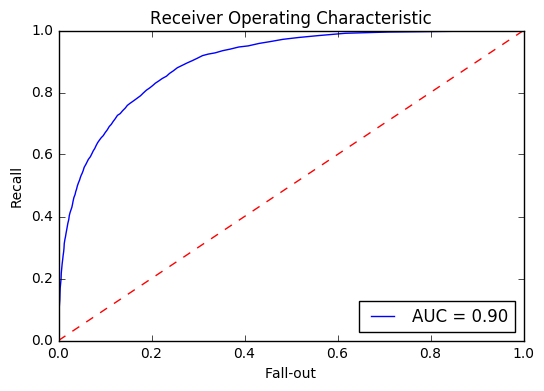

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = rf.predict_proba(X_test)

false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')

plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

### Tuning Models using GridSearch

In [67]:

pipeline2 = Pipeline([
('clf', RandomForestClassifier(criterion='entropy'))
])

parameters = {
    'clf__n_estimators': (5, 25, 50, 100),
    'clf__max_depth': (5, 25 , 50),
    'clf__min_samples_split': (2, 5, 10),
    'clf__min_samples_leaf': (1, 2, 3)
}

grid_search = GridSearchCV(pipeline2, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=3)

grid_search.fit(X_train, y_train)

print ('Best score: %0.3f' % grid_search.best_score_)

print ('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print ('\t%s: %r' % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(X_test)
print ('Accuracy:', accuracy_score(y_test, predictions))
print (classification_report(y_test, predictions))
    

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  3.2min finished


Best score: 0.860
Best parameters set:
	clf__max_depth: 50
	clf__min_samples_leaf: 2
	clf__min_samples_split: 5
	clf__n_estimators: 100
Accuracy: 0.858682138417
             precision    recall  f1-score   support

          0       0.88      0.94      0.91      9043
          1       0.76      0.63      0.69      3022

avg / total       0.85      0.86      0.85     12065



# Naive Bayes accuracy and time elapsed caculation


In [68]:
t4=time()
print ("NaiveBayes")
nb = BernoulliNB()
clf_nb=nb.fit(X_train,y_train)
print ("Acurracy: ", clf_nb.score(X_test,y_test))
t5=time()
print ("time elapsed: ", t5-t4)

NaiveBayes
Acurracy:  0.754910899295
time elapsed:  0.43802499771118164


## cross-validation for NB

In [69]:
tt4=time()
print ("cross result========")
scores = cross_validation.cross_val_score(nb, X, y, cv=5)
print (scores)
print (scores.mean())
tt5=time()
print ("time elapsed: ", tt5-tt4)

cross result========
[ 0.765  0.763  0.762  0.766  0.76 ]
0.763178730071
time elapsed:  1.200068473815918


# KNN accuracy and time elapsed caculation

In [70]:
t6=time()
print ("KNN")
# knn = KNeighborsClassifier(n_neighbors=3)
knn = KNeighborsClassifier()
clf_knn=knn.fit(X_train, y_train)
print ("Acurracy: ", clf_knn.score(X_test,y_test) )
t7=time()
print ("time elapsed: ", t7-t6)

KNN
Acurracy:  0.760464152507
time elapsed:  2.1001200675964355


## cross validation for KNN

In [71]:
tt6=time()
print ("cross result========")
scores = cross_validation.cross_val_score(knn, X, y, cv=5)
print (scores)
print (scores.mean())
tt7=time()
print ("time elapsed: ", tt7-tt6)

cross result========
[ 0.768  0.769  0.768  0.764  0.77 ]
0.76788674415
time elapsed:  10.268587589263916


___